# Studying the MNIST Dataset with TFLearn and TensorFlow

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of labelled handwritten digits.

The MNIST database is also widely used for training and testing in the field of machine learning, and is considered the 'Hello World' task of image processing.

In [1]:
# A bunch of imports, not very interesting
from __future__ import division, print_function, absolute_import

# utility packages
import random, os
import datetime as dt
import itertools as it

# TensorFlow is here
import tensorflow as tf
import tflearn

# For numerical computation
import numpy as np
import pandas as pd

# For plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10)

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Importing the data:

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Assigning the Training and Test Data

In [3]:
train_images = mnist.train.images.reshape([-1, 28, 28, 1])
train_labels = mnist.train.labels.astype(np.float32)

test_images = mnist.test.images.reshape([-1, 28, 28, 1])
test_labels = mnist.test.labels.astype(np.float32)

print("There are %d images in the training set" %len(mnist.train.images))
print("There are %d images in the test set"     %len(mnist.test.images))

There are 55000 images in the training set
There are 10000 images in the test set


## Visualising the Data

The MNIST Database consists of a collection of hand-drawn images, given as 28x28 pixel, black and white images.

Below we display a 10x10 grid of each of the images:

(-0.5, 279.5, 279.5, -0.5)

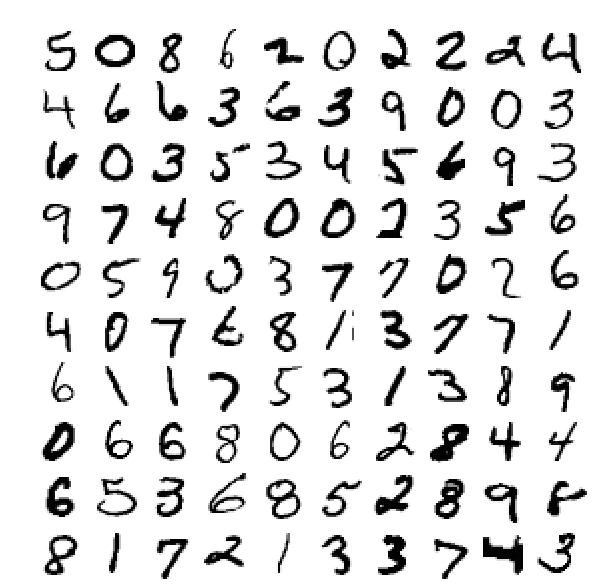

In [4]:
# Create grid of labels
label_grid = np.random.choice(range(len(train_labels)), 100)
label_grid = label_grid.reshape(10,10)

# Create grid of images
image_grid = []
for row in label_grid:
    image_grid.append(
        np.concatenate([train_images[i,:,:,:] for i in row], axis=1))
image_grid = np.concatenate(image_grid, axis=0)

# Display grid
plt.matshow(image_grid[:,:,0])
plt.axis('off')

## Building the Network

In [5]:
def bad_MNIST_net():
    '''Build simple neural network ~94% accuracy'''
    net = tflearn.input_data(shape=[None, 784])
    net = tflearn.fully_connected(net, 16, activation='relu', bias=True)
    net = tflearn.fully_connected(net, 10, activation='softmax')
    net = tflearn.regression(net)
    return net

In [6]:
net = bad_MNIST_net()
model = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir='tflearn_logs')

In [7]:
# Run this before training if using the fully_connected network
model_name   = 'bad_MNIST_net'
train_images = train_images.reshape(55000, 28 * 28)
test_images  =  test_images.reshape(10000, 28 * 28)

In [8]:
model_path = os.path.join("models", model_name)
if os.path.exists(model_path + ".meta"):
    model.load(model_path)
else:
    # retrain the model from scratch
    model.fit(train_images,
          train_labels,
          validation_set=(test_images, test_labels),
          n_epoch=10, 
          batch_size=100, 
          show_metric=True,
          run_id=model_name)

    # save the model to file
    model.save(model_path)

INFO:tensorflow:Restoring parameters from C:\Users\caleb\Documents\Data Science\mnist-in-tensorflow\Python\models\bad_MNIST_net


## Analysing the Model

Now we can take some time to analyse the accuracy of the model, in particular where the errors in the model are and why.

In [9]:
prediction = model.predict(test_images)
prediction = np.array(prediction)

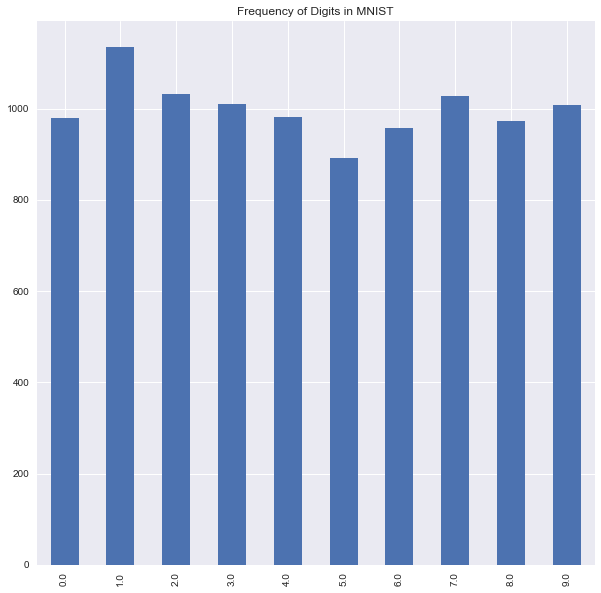

In [10]:
targets = np.dot(test_labels, np.arange(10))
targ_freqs = pd.Series(targets)\
               .value_counts()\
               .sort_index()
targ_freqs.plot(kind='bar',
                title='Frequency of Digits in MNIST')

## Confusion Matrix

Creating a confusion matrix sounds like a good idea.

In [11]:
target_matrix = np.dot(test_labels.T, test_labels)

In [28]:
def plot_matrix(matrix, palette = 'viridis', ticks=True):
    plt.matshow(matrix)
    plt.legend()
    plt.colorbar()
    plt.set_cmap(palette)
    plt.ylabel("Predicted Value")
    plt.grid('off')
    
    if ticks:
        plt.axis('on')
        plt.title("True Value")
        plt.xticks(range(10))
        plt.yticks(range(10))
    else:
        plt.axis('off')
        
    return p

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


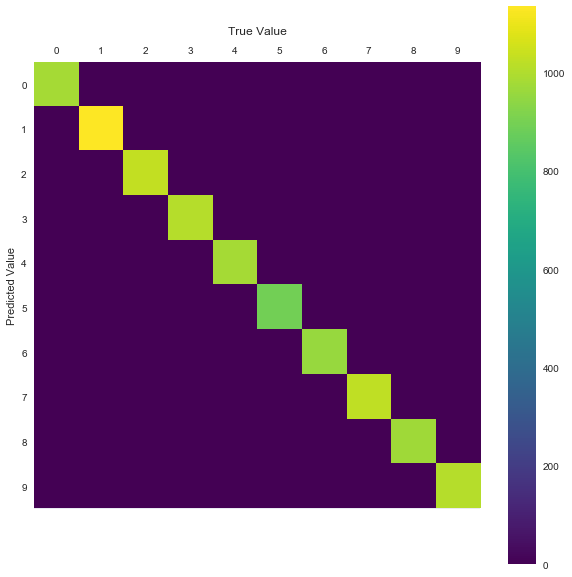

In [29]:
plot_matrix(target_matrix)

In [14]:
confusion_matrix = np.dot(test_labels.T, prediction)

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


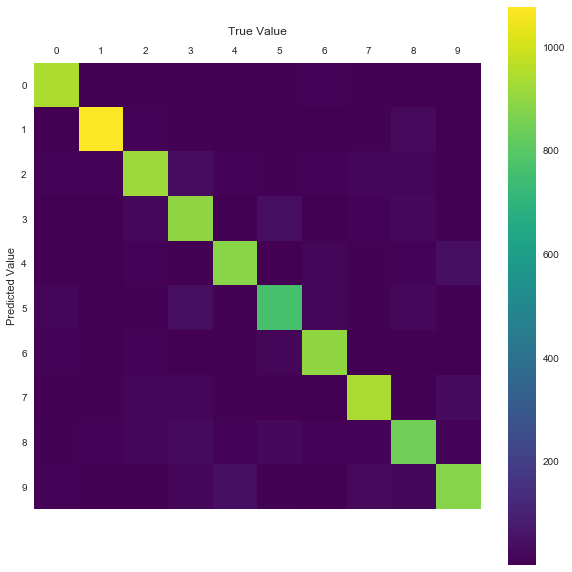

In [15]:
plot_matrix(confusion_matrix)

You can see here that the model is actually pretty good, and that it found the `1`s most easy to predict, and the `5`s and `8`s most difficult to predict. In fact you can sort of see that the model sometimes got the `5`s and `8`s mixed up. 

Next, we can rescale the colour map with a logarithm to increase the contrast in the image. This will allow us to better visualise what is going on in the blueish area of the confusion matrix.

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


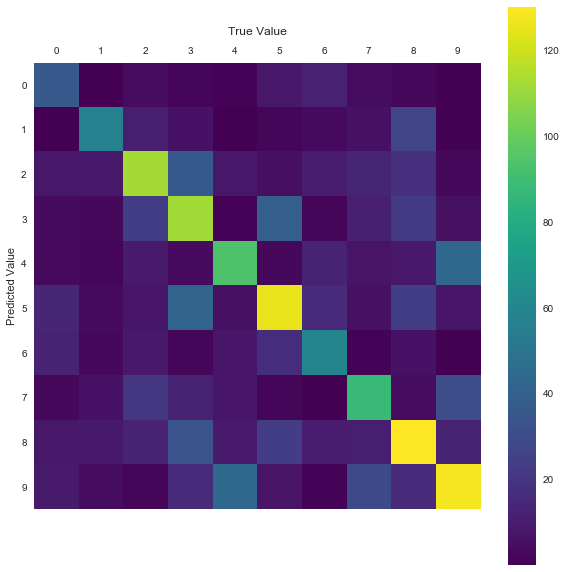

In [16]:
accuracy_matrix = np.abs(target_matrix - confusion_matrix)
plot_matrix(accuracy_matrix)

Now we can see where the problems are much more clearly. The 'hot colours' indicate predictions that were made with high certainty. In the case of the main diagonal, this means that the model made confident predictions that were also correct. Off the main diagonal however, hot spots indicate false positives that were predicted with high confidence.

With this in mind, we can notice a few features of the model. Firstly, in the top left you can see that `0`s and `1`s were rarely mistaken for one another with high confidence. This means that the model has a pretty good idea of what constitutes `0`-ness and `1`-ness.

One notable set of errors (although there are others) is with the `3`s. They are most commonly mistaken for 2s, 5s and 8s. Also interestingly, the model seems to pretty confidently distinguish `6`s and `9`s, which one might have expected them to get mixed up.

## Plotting the Accuracy of the Model

We can take a quick moment to plot the proportion of incorrect predictions from the model.

In [17]:
preds = np.argmax(prediction, axis=1)
targs = np.argmax(test_labels, axis=1)
hits = preds == targs

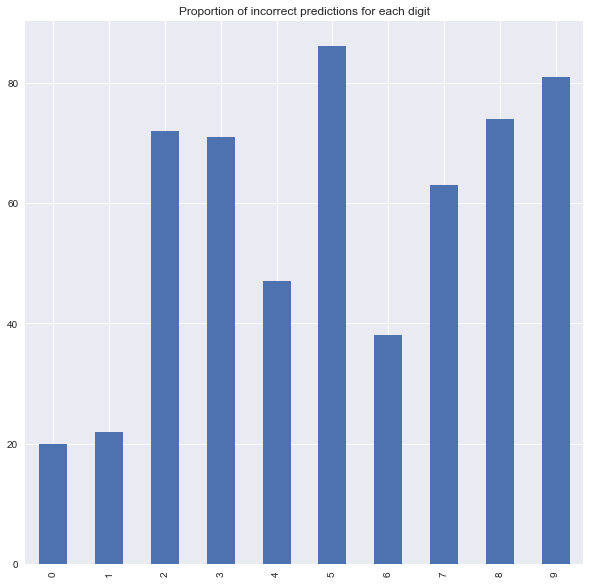

In [18]:
miss_freqs = pd.Series(targs[hits == False])\
               .value_counts()\
               .sort_index()
miss_freqs.plot(kind = 'bar',
                title = 'Proportion of incorrect predictions for each digit')

In [19]:
print("Validation Accuracy: %.2f%%" % round(100 * (1 - (miss_freqs/targ_freqs).mean()), 1))

Validation Accuracy: 94.20%


## Sampling from the Confusion Matrix

Here I would like to be able to select out examples of digits that look like other digits. For example, to find some `9`s that look like `7`s etc.

In [20]:
def mask_by_classification(pred, targ):
    '''Returns a digit that the model misclassified as pred
       when the true value was targ'''
    mask = np.logical_and(preds == pred, targs == targ)
    return mask

In [21]:
def entropy(x):
    return -x * np.log(x)

In [22]:
entropies = np.sum(entropy(prediction), axis=1)

In [23]:
res = []
for i, j in it.product(range(10), range(10)):
    mask = mask_by_classification(i, j)
    pred = prediction[mask]
    test = test_images[mask]
    
    if not np.any(mask):
        res.append(np.zeros(shape=(28,28)))
    else:
        index = np.argmin(entropies[mask])
        res.append(test[index].reshape(28,28) * accuracy_matrix[i, j])

In [24]:
rows = []
for r in range(0, 100, 10):
    row = res[r:r+10]
    rows.append(np.concatenate(row, axis=1))
image = np.concatenate(rows, axis=0)

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


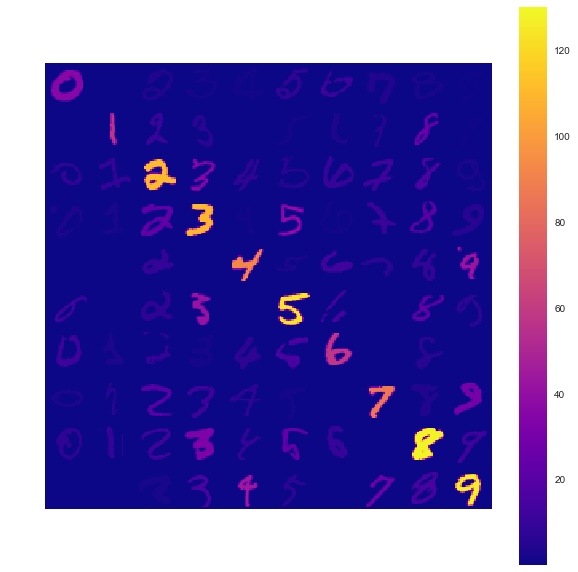

In [33]:
plot_matrix(image, palette = 'plasma', ticks=False)

C:\Users\caleb\AppData\Local\conda\conda\envs\tensorflow-env\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


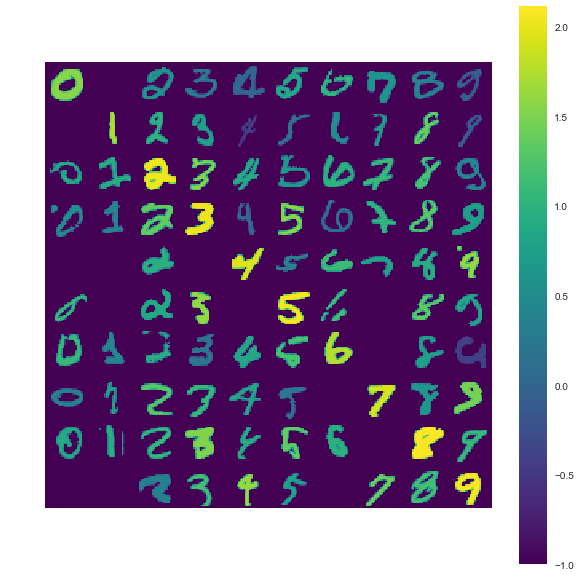

In [26]:
log_image = image
log_image[log_image < 0.1] = 0.1
log_image = np.log10(log_image)
plot_matrix(log_image, ticks=False)